In [1]:
import zipfile
path_to_zip_file = "/kaggle/input/dogs-vs-cats/train.zip"
directory_to_extract_to = "/kaggle/working/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [2]:
import os

folder_path = '/kaggle/working/train/'
folder_contents = os.listdir(folder_path)
folder_contents = [folder_path + image_path for image_path in folder_contents]

# print(folder_contents)
print(len(folder_contents))

25000


In [3]:
print(folder_contents[0])

/kaggle/working/train/dog.3559.jpg


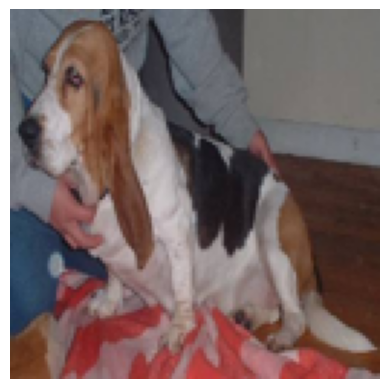

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

sample_image = Image.open(folder_contents[0]).resize((128,128))
show_image(sample_image)

In [5]:
train_split = 0.8
train_size = int(train_split * len(folder_contents))
train_content = folder_contents[:train_size]
valid_content = folder_contents[train_size:]

In [6]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class CatDogDataset(Dataset):
    def __init__(self, folder_contents, transform):
        self.folder_contents = folder_contents
        self.transform = transform
        
    def __len__(self):
        return len(self.folder_contents)
    
    def __getitem__(self, idx):
        image_path = self.folder_contents[idx]
        image = Image.open(image_path)
        label = 0 # 0 is dog, 1 is cat
        if "cat" in image_path: label = 1
        return self.transform(image).float() / 255.0, torch.Tensor([label])

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [8]:
train_dataset = CatDogDataset(train_content, transform)
valid_dataset = CatDogDataset(valid_content, transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=16)
valid_loader = DataLoader(valid_dataset, batch_size=16)

In [10]:
print(len(train_loader))
for image, label in train_loader:
    print(image.shape)
    print(label.shape)
    break

1250
torch.Size([16, 3, 128, 128])
torch.Size([16, 1])


In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet18 model (you can choose other models as well)
pretrained_resnet = models.resnet18(pretrained=True)

# Freeze all layers except the final classifier layers
for param in pretrained_resnet.parameters():
    param.requires_grad = False

# Modify the classifier layers for your specific task
num_classes = 1  # Replace with the number of classes in your dataset
pretrained_resnet.fc = nn.Sequential(
    nn.Linear(512, num_classes),
    nn.Sigmoid()
)

In [34]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    for image, label in tqdm(dataloader):
        image, label = image.to(device), label.to(device)
        # get prediction
        preds = model(image)
        loss = loss_fn(preds, label)
        
        # update weights
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()  # Compute gradients
        optimizer.step()
        
        # add to total loss count
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [35]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = pretrained_resnet.to(device)
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-4)

In [36]:
NO_EPOCHS = 5
for epoch in range(NO_EPOCHS):
    epoch_loss = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f"Epoch {epoch+1} loss: {epoch_loss}")

100%|██████████| 1250/1250 [01:01<00:00, 20.17it/s]


Epoch 1 loss: 0.24559003318846226


100%|██████████| 1250/1250 [01:01<00:00, 20.30it/s]


Epoch 2 loss: 0.2420002207517624


100%|██████████| 1250/1250 [01:02<00:00, 19.90it/s]


Epoch 3 loss: 0.2392368837893009


100%|██████████| 1250/1250 [01:01<00:00, 20.21it/s]


Epoch 4 loss: 0.23700353567004204


100%|██████████| 1250/1250 [01:03<00:00, 19.79it/s]

Epoch 5 loss: 0.2351470740109682


In [37]:
def evaluate(model, dataloader):
    model.eval()
    
    total_correct = 0
    total = 0
    for image, label in tqdm(dataloader):
        image, label = image.to(device), label.to(device)
        # get prediction
        preds = model(image).round()
        correct = (preds == label).sum()
        total += preds.shape[0]
        total_correct += correct
        
    return total_correct / total

In [38]:
accuracy = evaluate(model, valid_loader) * 100
print(f"Accuracy: {accuracy.round()}%")

100%|██████████| 313/313 [00:15<00:00, 19.98it/s]

Accuracy: 92.0%


In [39]:
def predict(image):
    m_image = image.to(device).unsqueeze(0)
    preds = model(m_image)
    image *= 256
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(image)
    show_image(pil_image)
    confidence = (preds*100).round().item()
    if preds.round().item() == 1.0: print(f"Cat with {confidence}% confidence")
    else: print(f"Dog with {100-confidence}% confidence")

In [40]:
def test_image(image_path):
    image = transform(Image.open(image_path)).float() / 255.0
    predict(image)

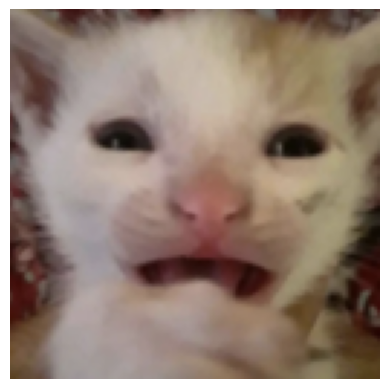

Cat with 97.0% confidence


In [41]:
test_image("/kaggle/input/test-cat-vs-dog/cat_cry.png")

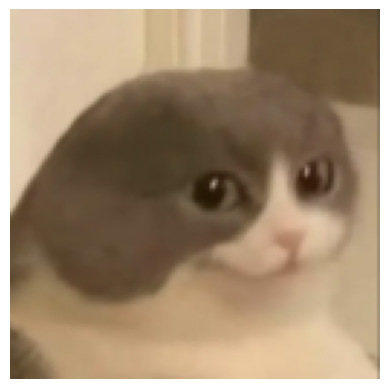

Cat with 90.0% confidence


In [42]:
test_image("/kaggle/input/test-cat-vs-dog/cat_no_ears.png")

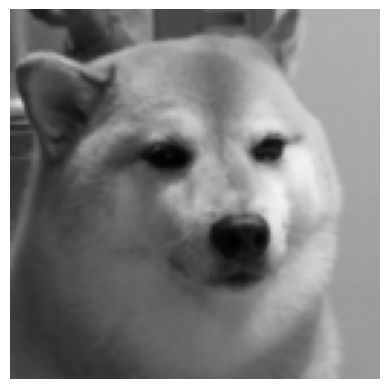

Dog with 99.0% confidence


In [43]:
test_image("/kaggle/input/test-cat-vs-dog/doggo_angry.png")

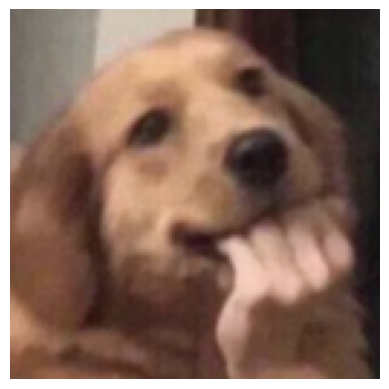

Dog with 100.0% confidence


In [44]:
test_image("/kaggle/input/test-cat-vs-dog/doggo_hand.png")

### `Done by Eng / Ahmed Salem`